# Buliding basic GAN and WGAN model using fashion-MNIST

Useful reads:
* https://medium.com/datadriveninvestor/deep-learning-generative-adversarial-network-gan-34abb43c0644
* https://github.com/Goldesel23/DCGAN-for-Bird-Generation
* https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

**Generative and Adversarial Network (GAN)** is an unsupervised deep learning algorithm where we have a Generator pitted against an adversarial network called Discriminator. Implementation of CNN in GAN results in deep convolutional GAN (DCGAN).

A ***discriminator*** estimates the probability of a given sample coming from the real dataset (how real the image is?). Its job is to tell the fake images from the real ones.
A ***generator*** generates arbitrary samples from a random noise in a latent vector. It's job is to capture the distribution of real data and to generate realistic syntetic images. The goal of a generator is to trick the discriminator to label fake images as real images.

In [1]:
from keras.datasets import fashion_mnist
from keras.layers import Input,Dense,Reshape,Flatten,Dropout,BatchNormalization,Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D,Conv2D,Conv2DTranspose
from keras.models import Model,Sequential
from keras.optimizers import Adam,RMSprop
from keras.initializers import RandomNormal
from keras import backend
from keras.constraints import Constraint

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1
latent_dim = 100 # latent vector space
img_shape = (img_rows,img_cols,channels)

# GAN
## Discriminator and Generator
* Activation: *LeakyReLU* for Generator and Discriminator
* Initialization: Gaussian (mean: 0, std: 0.02)
* Optimizer: Adam (lr: 0.0002, beta_1: 0.5)

***Discriminator***
* *sigmoid* activation for the top layer
* Use (2,2) strides for downsampling, instead of typical maxpooling

***Generator***
* *tanh* activation for the top layer

In [3]:
optimizer = Adam(0.0002,0.5)

### Discriminator (image --> real or fake)

In [4]:
model_disc = Sequential()
init = RandomNormal(mean=0.0, stddev=0.02)

model_disc.add(Conv2D(32,3,strides=(2,2),padding='same',kernel_initializer=init,input_shape=img_shape))
model_disc.add(LeakyReLU(alpha=0.2))
model_disc.add(Dropout(0.25))
model_disc.add(Conv2D(64,3,strides=(2,2),padding='same',kernel_initializer=init))
model_disc.add(BatchNormalization(momentum=0.8))
model_disc.add(LeakyReLU(alpha=0.2))
model_disc.add(Dropout(0.25))
model_disc.add(Conv2D(128,3,strides=(2,2),padding='same',kernel_initializer=init))
model_disc.add(BatchNormalization(momentum=0.8))
model_disc.add(LeakyReLU(alpha=0.2))
model_disc.add(Dropout(0.25))
model_disc.add(Conv2D(256,3,strides=(1,1),padding='same',kernel_initializer=init))
model_disc.add(BatchNormalization(momentum=0.8))
model_disc.add(LeakyReLU(alpha=0.2))
model_disc.add(Dropout(0.25))
model_disc.add(Flatten())
model_disc.add(Dense(1,activation='sigmoid'))

inputs_disc = Input(shape=img_shape)
outputs_disc = model_disc(inputs_disc)
discriminator = Model(inputs_disc,outputs_disc)

### Generator (latent vector --> image)

In [5]:
model_gen = Sequential()
init = RandomNormal(mean=0.0, stddev=0.02)

model_gen.add(Dense(7*7*128,activation='relu',kernel_initializer=init,input_dim=latent_dim))
model_gen.add(Reshape((7,7,128)))
model_gen.add(UpSampling2D())
model_gen.add(Conv2DTranspose(128,3,padding='same',kernel_initializer=init))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Activation('relu'))
model_gen.add(UpSampling2D())
model_gen.add(Conv2DTranspose(64,3,padding='same',kernel_initializer=init))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Activation('relu'))
model_gen.add(Conv2DTranspose(channels,3,padding='same',kernel_initializer=init))
model_gen.add(Activation('tanh'))

inputs_gen = Input(shape=(latent_dim,))
outputs_gen = model_gen(inputs_gen)
generator = Model(inputs_gen,outputs_gen)

### Building Adversarial model (generator + discriminator) and compiling

In [6]:
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)

fake_img = generator(inputs_gen)
discriminator.trainable = False ##train generator only in the adversarial model
valid = discriminator(fake_img)

## adversarial model
adver = Model(inputs_gen,valid)
adver.compile(loss='binary_crossentropy',optimizer=optimizer)

### Training GAN
* Sample noise from a standard Gaussian distribution (mean: 0, std: 1)
* Discriminator and Adversarial (or generator) models are trained simultaneously to reach a Nash equilibrium
* This does not guarantee the model convergence

***Object***
* discriminator: to minimize the classification error
* generator: to maximize the classification error

In [7]:
batch_size = 64
noise_plot = np.random.normal(0,1,(batch_size,latent_dim))

In [8]:
def train(epochs,batch_size=batch_size,save_interval=50):
    (X_train,_),(_,_) = fashion_mnist.load_data()
    
    # rescale real images to -1 to 1 since we are using tanh in generator
    X_train = X_train.astype('float32')
    X_train = X_train/127.5-1.
    X_train = np.expand_dims(X_train,axis=3)
    
    disc_loss_real_list = []
    disc_loss_fake_list = []
    disc_loss_list = []
    gen_loss_list = []
    
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for epoch in range(epochs+1):
        # train discriminator: full batch from real and full batch from fake  
        idx = np.random.randint(0,X_train.shape[0],batch_size)
        imgs = X_train[idx]
        
        #sample noise from latent vector and generate a full batch of fake images
        noise = np.random.normal(0,1,(batch_size,latent_dim))
        fake_imgs = generator.predict(noise)
        
        #train discriminator first (real as ones, fake as zeros) // factor of 0.5 since we used 2 full batchs
        disc_loss_real = 0.5*discriminator.train_on_batch(imgs,real)
        disc_loss_fake = 0.5*discriminator.train_on_batch(fake_imgs,fake)
        disc_loss = np.add(disc_loss_real,disc_loss_fake) # need to minimize
        
        disc_loss_real_list.append(disc_loss_real)
        disc_loss_fake_list.append(disc_loss_fake)
        disc_loss_list.append(disc_loss)
        
        # train generator: full batch
        noise = np.random.normal(0,1,(batch_size,latent_dim))
        gen_loss = adver.train_on_batch(noise,real) ## need to maximize
        gen_loss_list.append(gen_loss)
        
#         print('[epoch {}]: Disc loss: {:.3f}, Gen loss: {:.3f}'.format(epoch,disc_loss,gen_loss))
        
        if epoch % save_interval == 0:
            rows,cols = 4,4
            fake_imgs_plot = generator.predict(noise_plot)
            # rescale images 0 - 1 from -1 - 1
            fake_imgs_plot = (0.5*fake_imgs_plot) + 0.5

            fig,axes = plt.subplots(rows,cols,figsize=(10,10))
            img_num=0
            for i in range(rows):
                for j in range(cols):
                    axes[i,j].imshow(fake_imgs_plot[img_num,:,:,0],cmap='gray')
                    axes[i,j].axis('off')
                    img_num += 1
            plt.subplots_adjust(hspace=0.2,left=0.2, wspace=0.02)
            fig.savefig('GAN_images/fmnist_{}.png'.format(epoch))
            plt.close()
    return disc_loss_real_list,disc_loss_fake_list,disc_loss_list,gen_loss_list

In [9]:
disc_loss_real_list,disc_loss_fake_list,disc_loss_list,gen_loss_list = train(epochs=5000,batch_size=64,save_interval=50)

c:\users\sungsooc\appdata\local\continuum\anaconda3\envs\cv-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


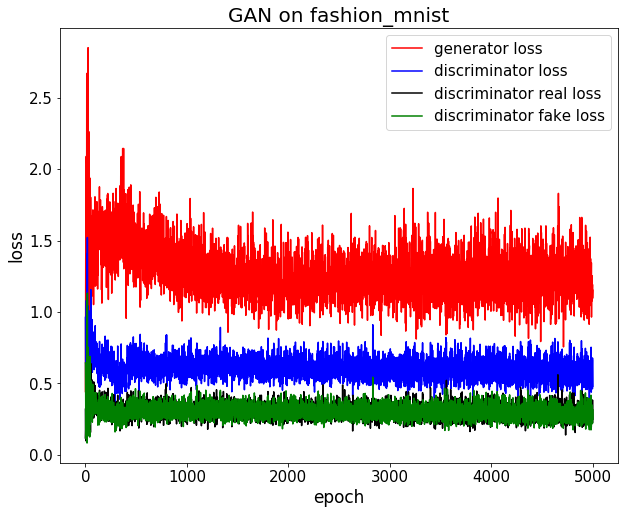

In [10]:
plt.figure(figsize=(10,8))
plt.plot(gen_loss_list,'r',label='generator loss')
plt.plot(disc_loss_list,'b',label='discriminator loss')
plt.plot(disc_loss_real_list,'k',label='discriminator real loss')
plt.plot(disc_loss_fake_list,'g',label='discriminator fake loss')
plt.title('GAN on fashion_mnist',fontsize=20)
plt.xlabel('epoch',fontsize=17)
plt.ylabel('loss',fontsize=17)
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()

# WGAN
***GAN*** loss does not reflect the quality of the generated images; it simply measures how well the generated images tricks the discriminator. It means that the learning process of GAN cannot be monitored by its loss metrics. The set of images need to be visually evaluated once in a while which can be highly subjective. 

***Wasserstein Generative and Adversarial Network (WGAN)*** utilizes a different loss function from GAN. Wasserstein Distance is a measure of the distance between two probability distributions and WGAN loss function reflects the image quality.

## Critic and Generator
* In WGAN, discriminator is replaced by critic to score the realness (or fakeness) of a given image, where the difference between the scores is as large as possible
* WGAN encourages the critic to output scores that are different for real and fake images
* Wasserstein loss to train the critic and generator models
* Use -1 labels for real images and 1 labels for fake images (or vice versa)
* Optimizer: RMSProp with no momentum (lr: 0.00005)

***Critic***
* linear activation function in the top layer (instead of sigmoid)
* Clip the weights of a critic model to [-0.01,0.01] after each mini batch update
* Update the critic model more times than the generator each iteration

In [11]:
def wasserstein_loss(y_true,y_pred):
    return backend.mean(y_true*y_pred)

In [12]:
class ClipConstraint(Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    def get_config(self):
        return {'clip_value': self.clip_value}

In [13]:
optimizer = RMSprop(lr=0.00005)

### Critic (former Discriminator)

In [14]:
model_crit = Sequential()
init = RandomNormal(mean=0.0, stddev=0.02)
const = ClipConstraint(0.01)

model_crit.add(Conv2D(32,3,strides=(2,2),padding='same',kernel_initializer=init,kernel_constraint=const,input_shape=img_shape))
model_crit.add(LeakyReLU(alpha=0.2))
model_crit.add(Dropout(0.25))
model_crit.add(Conv2D(64,3,strides=(2,2),padding='same',kernel_initializer=init,kernel_constraint=const))
model_crit.add(BatchNormalization(momentum=0.8))
model_crit.add(LeakyReLU(alpha=0.2))
model_crit.add(Dropout(0.25))
model_crit.add(Conv2D(128,3,strides=(2,2),padding='same',kernel_initializer=init,kernel_constraint=const))
model_crit.add(BatchNormalization(momentum=0.8))
model_crit.add(LeakyReLU(alpha=0.2))
model_crit.add(Dropout(0.25))
model_crit.add(Conv2D(256,3,strides=(1,1),padding='same',kernel_initializer=init,kernel_constraint=const))
model_crit.add(BatchNormalization(momentum=0.8))
model_crit.add(LeakyReLU(alpha=0.2))
model_crit.add(Dropout(0.25))
model_crit.add(Flatten())
model_crit.add(Dense(1,activation='linear'))

inputs_crit = Input(shape=img_shape)
outputs_crit = model_crit(inputs_crit)
critic = Model(inputs_crit,outputs_crit)
critic.compile(loss=wasserstein_loss,optimizer=optimizer)

### Generator

In [15]:
model_gen = Sequential()
init = RandomNormal(mean=0.0, stddev=0.02)

model_gen.add(Dense(7*7*128,activation='relu',kernel_initializer=init,input_dim=latent_dim))
model_gen.add(Reshape((7,7,128)))
model_gen.add(UpSampling2D())
model_gen.add(Conv2DTranspose(128,3,padding='same',kernel_initializer=init))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Activation('relu'))
model_gen.add(UpSampling2D())
model_gen.add(Conv2DTranspose(64,3,padding='same',kernel_initializer=init))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Activation('relu'))
model_gen.add(Conv2DTranspose(channels,3,padding='same',kernel_initializer=init))
model_gen.add(Activation('tanh'))

inputs_gen = Input(shape=(latent_dim,))
outputs_gen = model_gen(inputs_gen)
generator = Model(inputs_gen,outputs_gen)

In [16]:
fake_img = generator(inputs_gen)
critic.trainable=False ##train generator only in the combined model
valid = critic(fake_img)

## adversarial model
adver = Model(inputs_gen,valid)
adver.compile(loss=wasserstein_loss,optimizer=optimizer)

In [17]:
def train(epochs,batch_size=batch_size,save_interval=50):
    (X_train,_),(_,_) = fashion_mnist.load_data()
    # rescale real images to -1 to 1 since we are using tanh
    X_train = X_train.astype('float32')
    X_train = X_train/127.5-1.
    X_train = np.expand_dims(X_train,axis=3)
    
    n_critic = 7
    crit_loss_real_temp = []
    crit_loss_fake_temp = []
    crit_loss_real_list = []
    crit_loss_fake_list = []
    crit_loss_list = []
    gen_loss_list = []
    
    real = -np.ones((batch_size,1)) 
    fake = np.ones((batch_size,1)) 
    
    for epoch in range(epochs):
        for _ in range(n_critic): 
        # train critic
            idx=np.random.randint(0,X_train.shape[0],batch_size)
            imgs = X_train[idx]
            
            #sample noise from latent vector and generate a half batch of fake images
            noise = np.random.normal(0,1,(batch_size,latent_dim))
            fake_imgs = generator.predict(noise)

            #train critics (real as ones, gen as zeros)
            crit_loss_real = 0.5*critic.train_on_batch(imgs,real)
            crit_loss_fake = 0.5*critic.train_on_batch(fake_imgs,fake)
            crit_loss_real_temp.append(crit_loss_real)
            crit_loss_fake_temp.append(crit_loss_fake)
        
        crit_loss_real = np.mean(crit_loss_real_temp)
        crit_loss_fake = np.mean(crit_loss_fake_temp)
        crit_loss = np.add(crit_loss_real,crit_loss_fake)
        crit_loss_real_list.append(crit_loss_real)
        crit_loss_fake_list.append(crit_loss_fake)
        crit_loss_list.append(crit_loss)

        # train generator
        noise = np.random.normal(0,1,(batch_size,latent_dim))
        gen_loss = adver.train_on_batch(noise,real)
        gen_loss_list.append(gen_loss)
        
#         print('[epoch {}]: Disc loss: {:.3f}, Gen loss: {:.3f}'.format(epoch,crit_loss,gen_loss))
                
        if epoch % save_interval == 0:
            rows,cols = 4,4
            fake_imgs_plot = generator.predict(noise_plot)
            # rescale images 0 - 1 from -1 - 1
            fake_imgs_plot = (0.5*fake_imgs_plot) + 0.5

            fig,axes = plt.subplots(rows,cols,figsize=(10,10))
            img_num=0
            for i in range(rows):
                for j in range(cols):
                    axes[i,j].imshow(fake_imgs_plot[img_num,:,:,0],cmap='gray')
                    axes[i,j].axis('off')
                    img_num += 1
            plt.subplots_adjust(hspace=0.2,left=0.2, wspace=0.02)
            fig.savefig('WGAN_images/fmnist_{}.png'.format(epoch))
            plt.close()
    return crit_loss_real_list,crit_loss_fake_list,crit_loss_list,gen_loss_list

In [18]:
crit_loss_real_list,crit_loss_fake_list,crit_loss_list,gen_loss_list = train(epochs=5000,batch_size=64,save_interval=50)

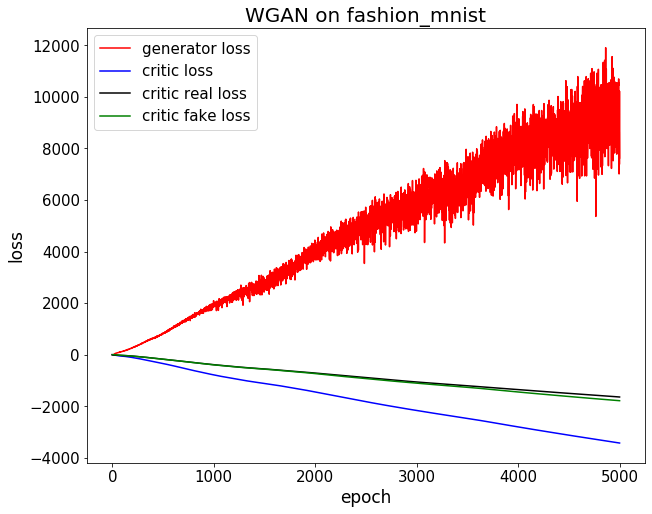

In [19]:
plt.figure(figsize=(10,8))
plt.plot(gen_loss_list,'r',label='generator loss')
plt.plot(crit_loss_list,'b',label='critic loss')
plt.plot(crit_loss_real_list,'k',label='critic real loss')
plt.plot(crit_loss_fake_list,'g',label='critic fake loss')
plt.title('WGAN on fashion_mnist',fontsize=20)
plt.xlabel('epoch',fontsize=17)
plt.ylabel('loss',fontsize=17)
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()